In [1]:
import torch.nn as nn
import lightning as L
import torch
import numpy as np
from PIL import Image
import os
import matplotlib.pyplot as plt

In [39]:
class AutoEncoder(L.LightningModule):
    def __init__(self, num_input_channels: int, base_channel_size: int, latent_dim: int, act_fn: object = nn.GELU):
            super().__init__()
            c_hid = base_channel_size
            self.encoder = nn.Sequential(
                nn.Conv2d(num_input_channels, c_hid, kernel_size=3, padding=1, stride=2),  # 408x408 => 204x204
                act_fn(),
                nn.Conv2d(c_hid, c_hid, kernel_size=3, padding=1, stride=2), # 408x408 => 102x102
                act_fn(),
                nn.Conv2d(c_hid, 2 * c_hid, kernel_size=3, padding=1, stride=2),  # 102x102 => 53x53
                act_fn(),
                nn.Conv2d(2 * c_hid, 2 * c_hid, kernel_size=3, padding=1, stride=2), # 102x102 => 27x27
                act_fn(),
                nn.Conv2d(2 * c_hid, 2 * c_hid, kernel_size=3, padding=1, stride=2),  # 25x25 => 12x12
                act_fn(),
                nn.Flatten(),  # Image grid to single feature vector
                nn.Linear(2 * 169 * c_hid, latent_dim),
            )
            self.linear_decoder = nn.Sequential(
                nn.Linear(latent_dim, 2 * 169 * c_hid),
                act_fn()
            )
            self.decoder = nn.Sequential( 
                act_fn(),
                nn.ConvTranspose2d(2 * c_hid, 2 * c_hid, kernel_size=3, output_padding=1, padding=1, stride=2),  # 12x12 => 25x25
                act_fn(),
                nn.ConvTranspose2d(2 * c_hid, c_hid, kernel_size=3, output_padding=0, padding=1, stride=2),  # 25x25 => 51x51
                act_fn(),
                nn.ConvTranspose2d(c_hid, c_hid, kernel_size=3, output_padding=1, padding=1, stride=2),  # 51x51 => 102x102
                act_fn(),
                nn.ConvTranspose2d(c_hid, c_hid, kernel_size=3, output_padding=1, padding=1, stride=2),  # 102x102 => 204x204
                act_fn(),
                nn.ConvTranspose2d(c_hid, num_input_channels, kernel_size=3, output_padding=1, padding=1, stride=2),  # 204x204 => 408x408
                nn.Sigmoid()
            )
    def forward(self, x):
        x_ae = self.encoder(x)
        x_rec = self.linear_decoder(x_ae).reshape(x_ae.shape[0], -1, 13, 13)
        return self.decoder(x_rec)

    def encode(self, x):
        return self.encoder(x)

    def decode(self, x):
        x_rec = self.linear_decoder(x).reshape(x.shape[0], -1, 13, 13)
        return self.decoder(x_rec)

    def get_reconstruction_loss(self, x):
        x_pred = self.forward(x)
        loss = torch.nn.functional.mse_loss(x, x_pred, reduction = "none")
        return loss.mean()

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        # Using a scheduler is optional but can be helpful.
        # The scheduler reduces the LR if the validation performance hasn't improved for the last N epochs
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.2, patience=20, min_lr=5e-5)
        return {"optimizer": optimizer, "lr_scheduler": scheduler, "monitor": "val_loss"}

    def training_step(self, batch):
        x, _ = batch
        loss = self.get_reconstruction_loss(x)
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch):
        x, _ = batch
        loss = self.get_reconstruction_loss(x)
        self.log("val_loss", loss)
        return loss

# Look at reconstruction

In [40]:
model = AutoEncoder.load_from_checkpoint('logs/lightning_logs/version_1/checkpoints/epoch=99-step=2300.ckpt', num_input_channels=1, base_channel_size=24, latent_dim=100)

In [44]:
cmaps = os.listdir('cmaps')
maps = []
for map in cmaps:
    max_size = 408
    im_reshape = np.zeros((max_size, max_size))
    im = np.asarray(Image.open(os.path.join('cmaps', map)))
    im_correct = im[im.any(axis=1)][:, im.any(axis=0)]
    n, p = im_correct.shape
    # The data is rescalde between 0 and 1
    im_rescale = - (im_correct / 255) + 1
    # Center and reshape the data
    im_rescale = np.pad(im_rescale, [((max_size - n) // 2, (max_size - n) - (max_size - n) // 2), ((max_size - p) // 2, (max_size - p) - (max_size - p) // 2)])
    maps.append(im_rescale[None,:,:].astype(np.float32))

In [45]:
maps = torch.tensor(np.array(maps), dtype=torch.float32)

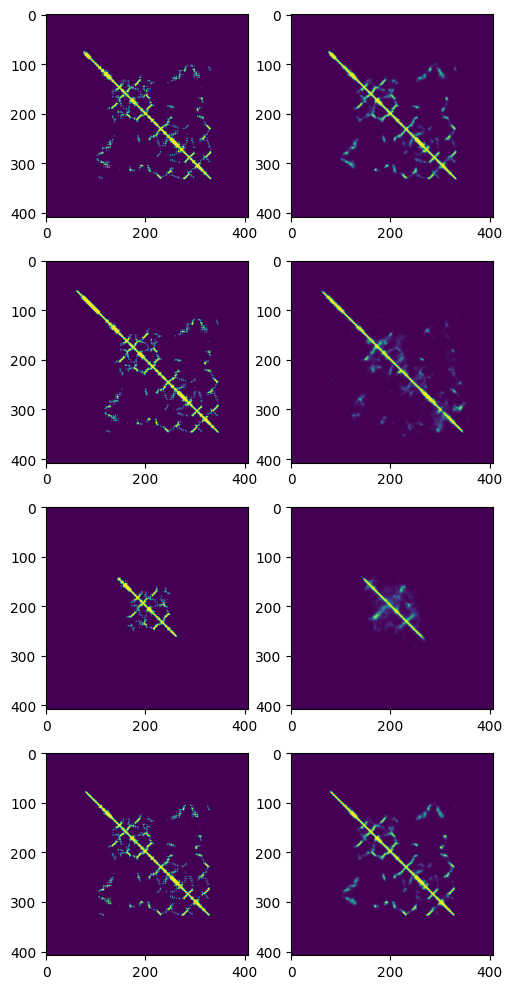

In [46]:
samples = np.random.choice(range(len(maps)), 4)
fig, ax = plt.subplots(4, 2, figsize = (15,10))

for j in range(len(ax)):
    ax[j,0].set_aspect('equal')
    ax[j,0].imshow(maps[j][0])
    pred = model.forward(maps[j].unsqueeze(dim=0)).detach().numpy()
    ax[j,1].set_aspect('equal')
    ax[j,1].imshow(pred[0,0])
plt.tight_layout()
plt.subplots_adjust(wspace=-0.8)
plt.show()

## PCA Analysis

In [41]:
encoded = model.encode(maps)

In [42]:
encoded = encoded.detach().numpy()
U,V,D = np.linalg.svd(encoded)

In [49]:
torch.tensor(encoded[j]).unsqueeze(dim=0).shape

torch.Size([1, 100])

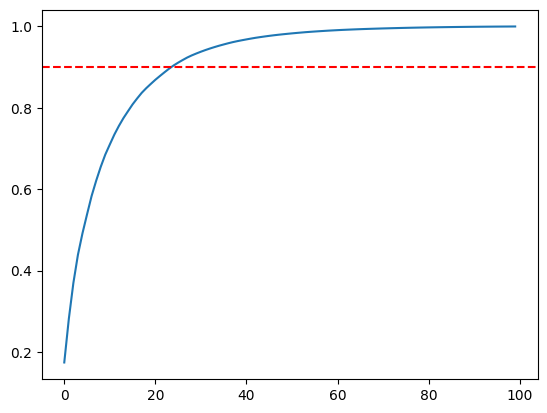

In [55]:
plt.plot(np.arange(len(V)), np.cumsum(V)/np.sum(V))
plt.axhline(0.9, c='r', linestyle = 'dashed')
plt.show()

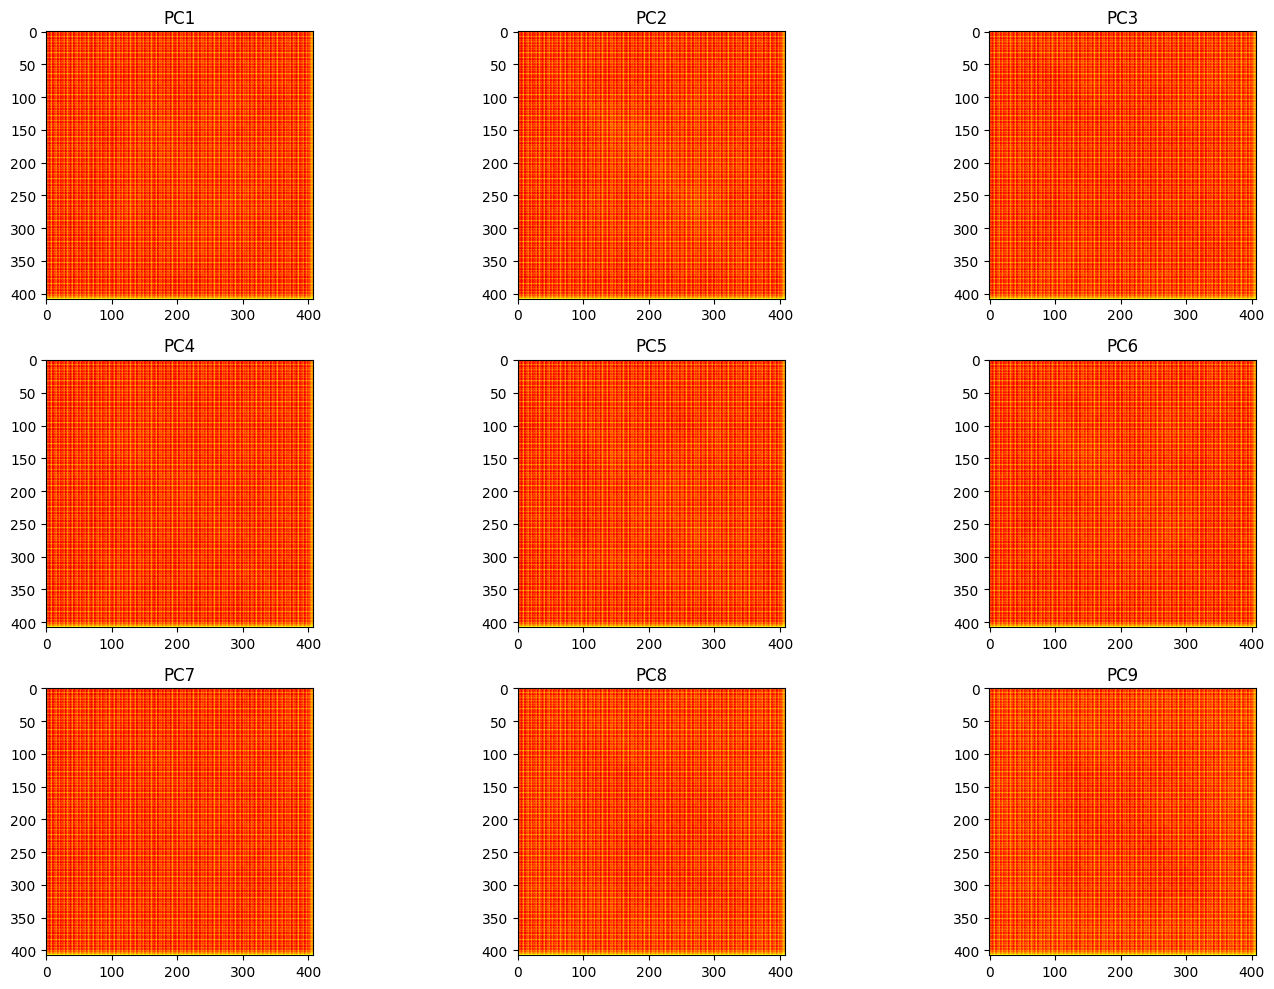

In [71]:
fig, ax = plt.subplots(3, 3, figsize = (15,10))

for j in range(ax.shape[0]*ax.shape[1]):
    ax[j//3, j%3].set_aspect('equal')
    pred = model.decode(torch.tensor(D[:,50+j]).unsqueeze(dim=0)).detach().numpy()
    ax[j//3, j%3].imshow(pred[0,0], cmap='hot')
    ax[j//3, j%3].set_title(f'PC{j+1}')

plt.tight_layout()
plt.show()

## Sandbox

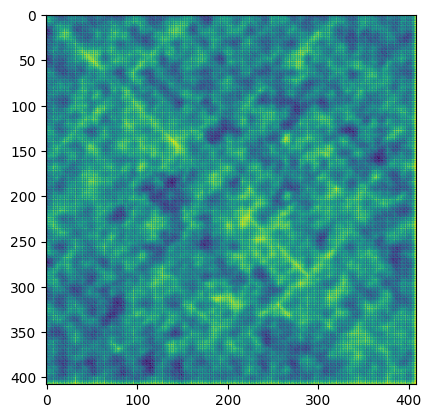

In [87]:
inputs = torch.zeros(1,100)
inputs[0,5] = 100
trial = model.decode(inputs).detach().numpy()
plt.imshow(trial[0,0])
plt.show()